## Practical 7 - Grover Algorithm

# Grover's Algo

In [19]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit[visualization]

In [20]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import math
import matplotlib.pyplot as plt

In [21]:
from qiskit import QuantumCircuit

def oracle_for_value(n_qubits, values, search_value):
    """
    Constructs an oracle which flips the phase of all indices
    where the element in 'values' equals 'search_value'.
    """
    oracle = QuantumCircuit(n_qubits, name='oracle')

    # Mark all indices i where values[i] == search_value
    for i, val in enumerate(values):
        if val == search_value:
            # --- This entire block must be indented ---

            # Apply X gates on qubits where the bit of i is '0'
            bits = format(i, f'0{n_qubits}b')
            for qubit, bit in enumerate(reversed(bits)):
                if bit == '0':
                    oracle.x(qubit)

            # Apply multi-controlled Z-gate (implemented with h, mcx, h)
            oracle.h(n_qubits - 1)
            oracle.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            oracle.h(n_qubits - 1)

            # Uncompute the X gates to return to the original state
            for qubit, bit in enumerate(reversed(bits)):
                if bit == '0':
                    oracle.x(qubit)

            # Optional: Add a barrier for better visualization between marked items
            oracle.barrier()

    return oracle

In [22]:
def diffuser( n_qubits ):
  diff = QuantumCircuit( n_qubits)
  diff.h( range(n_qubits))
  diff.x( range(n_qubits))
  diff.h( n_qubits - 1 )
  diff.mcx( list (range( n_qubits - 1 ) ), n_qubits - 1 )
  diff.h( n_qubits - 1 )
  diff.x( range( n_qubits ) )
  diff.h( range( n_qubits ) )
  return diff

In [23]:
def run_grover( n_qubits, oracle, search_value_occurrences ):
  iterations = math.floor( ( math.pi / 4 ) * math.sqrt( 2**n_qubits / search_value_occurrences ) )
  qc = QuantumCircuit( n_qubits, n_qubits )
  qc.h( range( n_qubits ) )
  diff = diffuser( n_qubits )
  for _ in range(iterations):
    qc.compose( oracle, inplace = True )
    qc.compose( diff, inplace = True )

  qc.measure( range( n_qubits ), range( n_qubits ) )
  simulator = AerSimulator()
  compiled_circuit = transpile( qc, simulator )
  result = simulator.run( compiled_circuit, shots=1024 ).result()
  counts = result.get_counts()
  return counts

In [24]:
values = [4, 2, 5, 8, 7]
search_value = 5

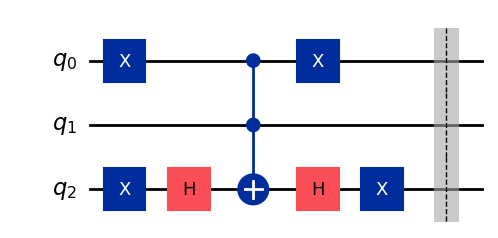

In [25]:
# Number of qubits to cover index range
n_qubits = 3
# Build oracle without target index knowledge
oracle = oracle_for_value( n_qubits, values, search_value )
oracle.draw(output='mpl')


Measurement counts (index of '5' showing high probability):
 {'010': 968, '000': 10, '011': 14, '110': 4, '111': 9, '100': 6, '101': 7, '001': 6}


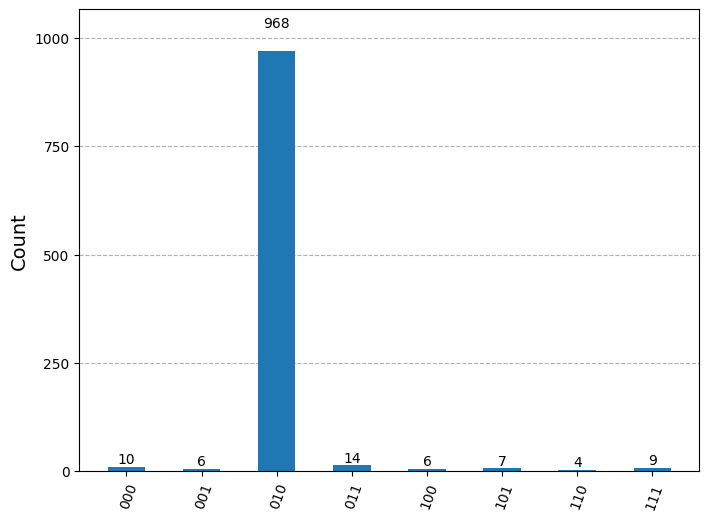

In [26]:


# How many indices have search_value? In this example just one
search_value_occurrences = 0
for i in range( len( values ) ):
  if values[ i ] == search_value:
    search_value_occurrences += 1
    counts = run_grover( n_qubits, oracle, search_value_occurrences )
print( f"Measurement counts (index of '{search_value}' showing high probability):\n", counts )
fig, ax = plt.subplots( figsize = ( 8, 6 ) ) # Create figure and axis
plot_histogram( counts, ax = ax )
plt.show()